# Prerequisites

The data utilized here comes from the Strava API and the Visual Crossing Weather API. Methods for acquiring the data can be found in `compile_user_laps.py` & `add_weather.py`. Methods utilized in the scripts are derived from the `StravaAPI` class, which is also available to you in the repository. The goal here is to try and identify any trends between weather and running before we try and throw a model at it.

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

strava_palette = {
    'Strava Orange': '#fc4c02',
    'Pumpkin': '#ff7518',
    'Coal': '#262626',
    'Asphalt': '#404040',
    'Gravel': '#757575',
    'Fog': '#d9d9d9',
    'Icicle': '#f0f0f0',
    'Silver': '#c0c0c0'
}

# Set the palette
sns.set_palette(list(strava_palette.values()))

laps_data = pd.read_csv('/Users/bennett/PycharmProjects/CAPi/laps_data.csv')
weather_data = pd.read_csv('/Users/bennett/PycharmProjects/CAPi/weather_data.csv')

running_data = laps_data.merge(weather_data, how='left', on=['name', 'activity_id'])

In [56]:
running_data.head()

,Unnamed: 0_x,id,resource_state,name,elapsed_time,moving_time,start_date,start_date_local,distance,average_speed,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,0,35896190589,2,Lap 1,404,404,2023-12-21T23:53:34Z,2023-12-21T18:53:34Z,1609.34,3.98,...,1029.2,2.7,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"
1,0,35896190589,2,Lap 1,404,404,2023-12-21T23:53:34Z,2023-12-21T18:53:34Z,1609.34,3.98,...,1029.2,2.7,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"
2,1,35896190591,2,Lap 2,403,403,2023-12-22T00:00:19Z,2023-12-21T19:00:19Z,1609.34,3.99,...,1029.1,2.4,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"
3,1,35896190591,2,Lap 2,403,403,2023-12-22T00:00:19Z,2023-12-21T19:00:19Z,1609.34,3.99,...,1029.1,2.4,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"
4,2,35896190594,2,Lap 3,442,401,2023-12-22T00:07:03Z,2023-12-21T19:07:03Z,1609.34,4.01,...,1029.1,2.4,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"


# Data Cleaning & Visualization

We'll remove the unwanted columns here. Furthermore, we need to reduce our dataset to only include non-null values for `start_lat` & `start_long`. This is because if there is no location for the activity lap, then `add_weather.py` won't return any relevant data and we won't be able to utilize the observation in modeling.

In [57]:
running_data = running_data[['activity_id', 'id', 'name', 'split', 'elapsed_time', 'distance', 'average_speed', 'average_heartrate', 'average_watts', 'average_cadence', 'max_speed', 'max_heartrate', 'total_elevation_gain', 'pace_zone', 'start_lat', 'start_long', 'datetime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'conditions']]

running_data.dropna(subset=['start_long', 'start_lat'], inplace=True)
running_data.drop_duplicates(inplace=True)

In [58]:
running_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3939 entries, 0 to 4202
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   activity_id           3939 non-null   int64  
 1   id                    3939 non-null   int64  
 2   name                  3939 non-null   object 
 3   split                 3939 non-null   int64  
 4   elapsed_time          3939 non-null   int64  
 5   distance              3939 non-null   float64
 6   average_speed         3939 non-null   float64
 7   average_heartrate     3900 non-null   float64
 8   average_watts         2625 non-null   float64
 9   average_cadence       3897 non-null   float64
 10  max_speed             3939 non-null   float64
 11  max_heartrate         3900 non-null   float64
 12  total_elevation_gain  3939 non-null   float64
 13  pace_zone             3939 non-null   int64  
 14  start_lat             3939 non-null   float64
 15  start_long            3939

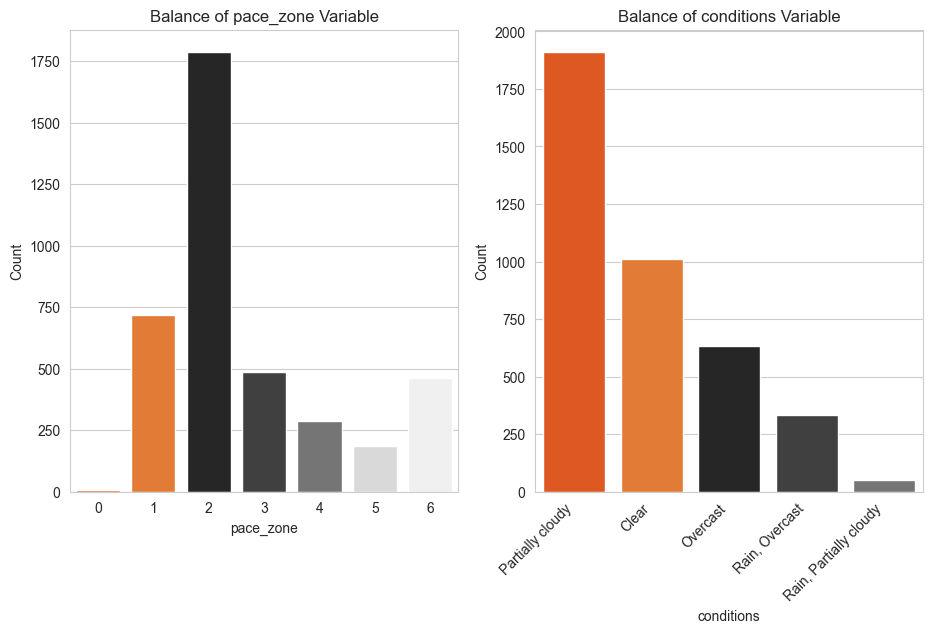

In [59]:
# Overall Figure (2x4 with 8 subplots). Flattening the axes will help seaborn do backend stuff faster.
fig, axes = plt.subplots(1, 2, figsize=(11, 6))
axes = axes.flatten()

# For each of our categorical columns, bar plot it and add it to the appropriate slot in the overall fig
# Enumerate because we need an iterator and the column
for i, column in enumerate(['pace_zone', 'conditions']):
    
    # Create a little mini df from the result of value_counts(), so we can plot it
    values = pd.DataFrame(running_data[column].value_counts().reset_index())
    values.columns = [column, 'Count']
    
    sns.barplot(data=values, x=column, y='Count', ax=axes[i])
    axes[i].set_title(f'Balance of {column} Variable')

axes[1].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
plt.show()

It looks like we can change `conditions` and `pace_zone` to categorical datatypes. Furthermore, `datetime` loaded in as an object. We'll want to update that to the appropriate datatype here as well.

In [60]:
running_data['datetime'] = pd.to_datetime(running_data['datetime'])
running_data['conditions'] = running_data['conditions'].astype('category')
running_data['pace_zone'] = running_data['pace_zone'].astype('category')

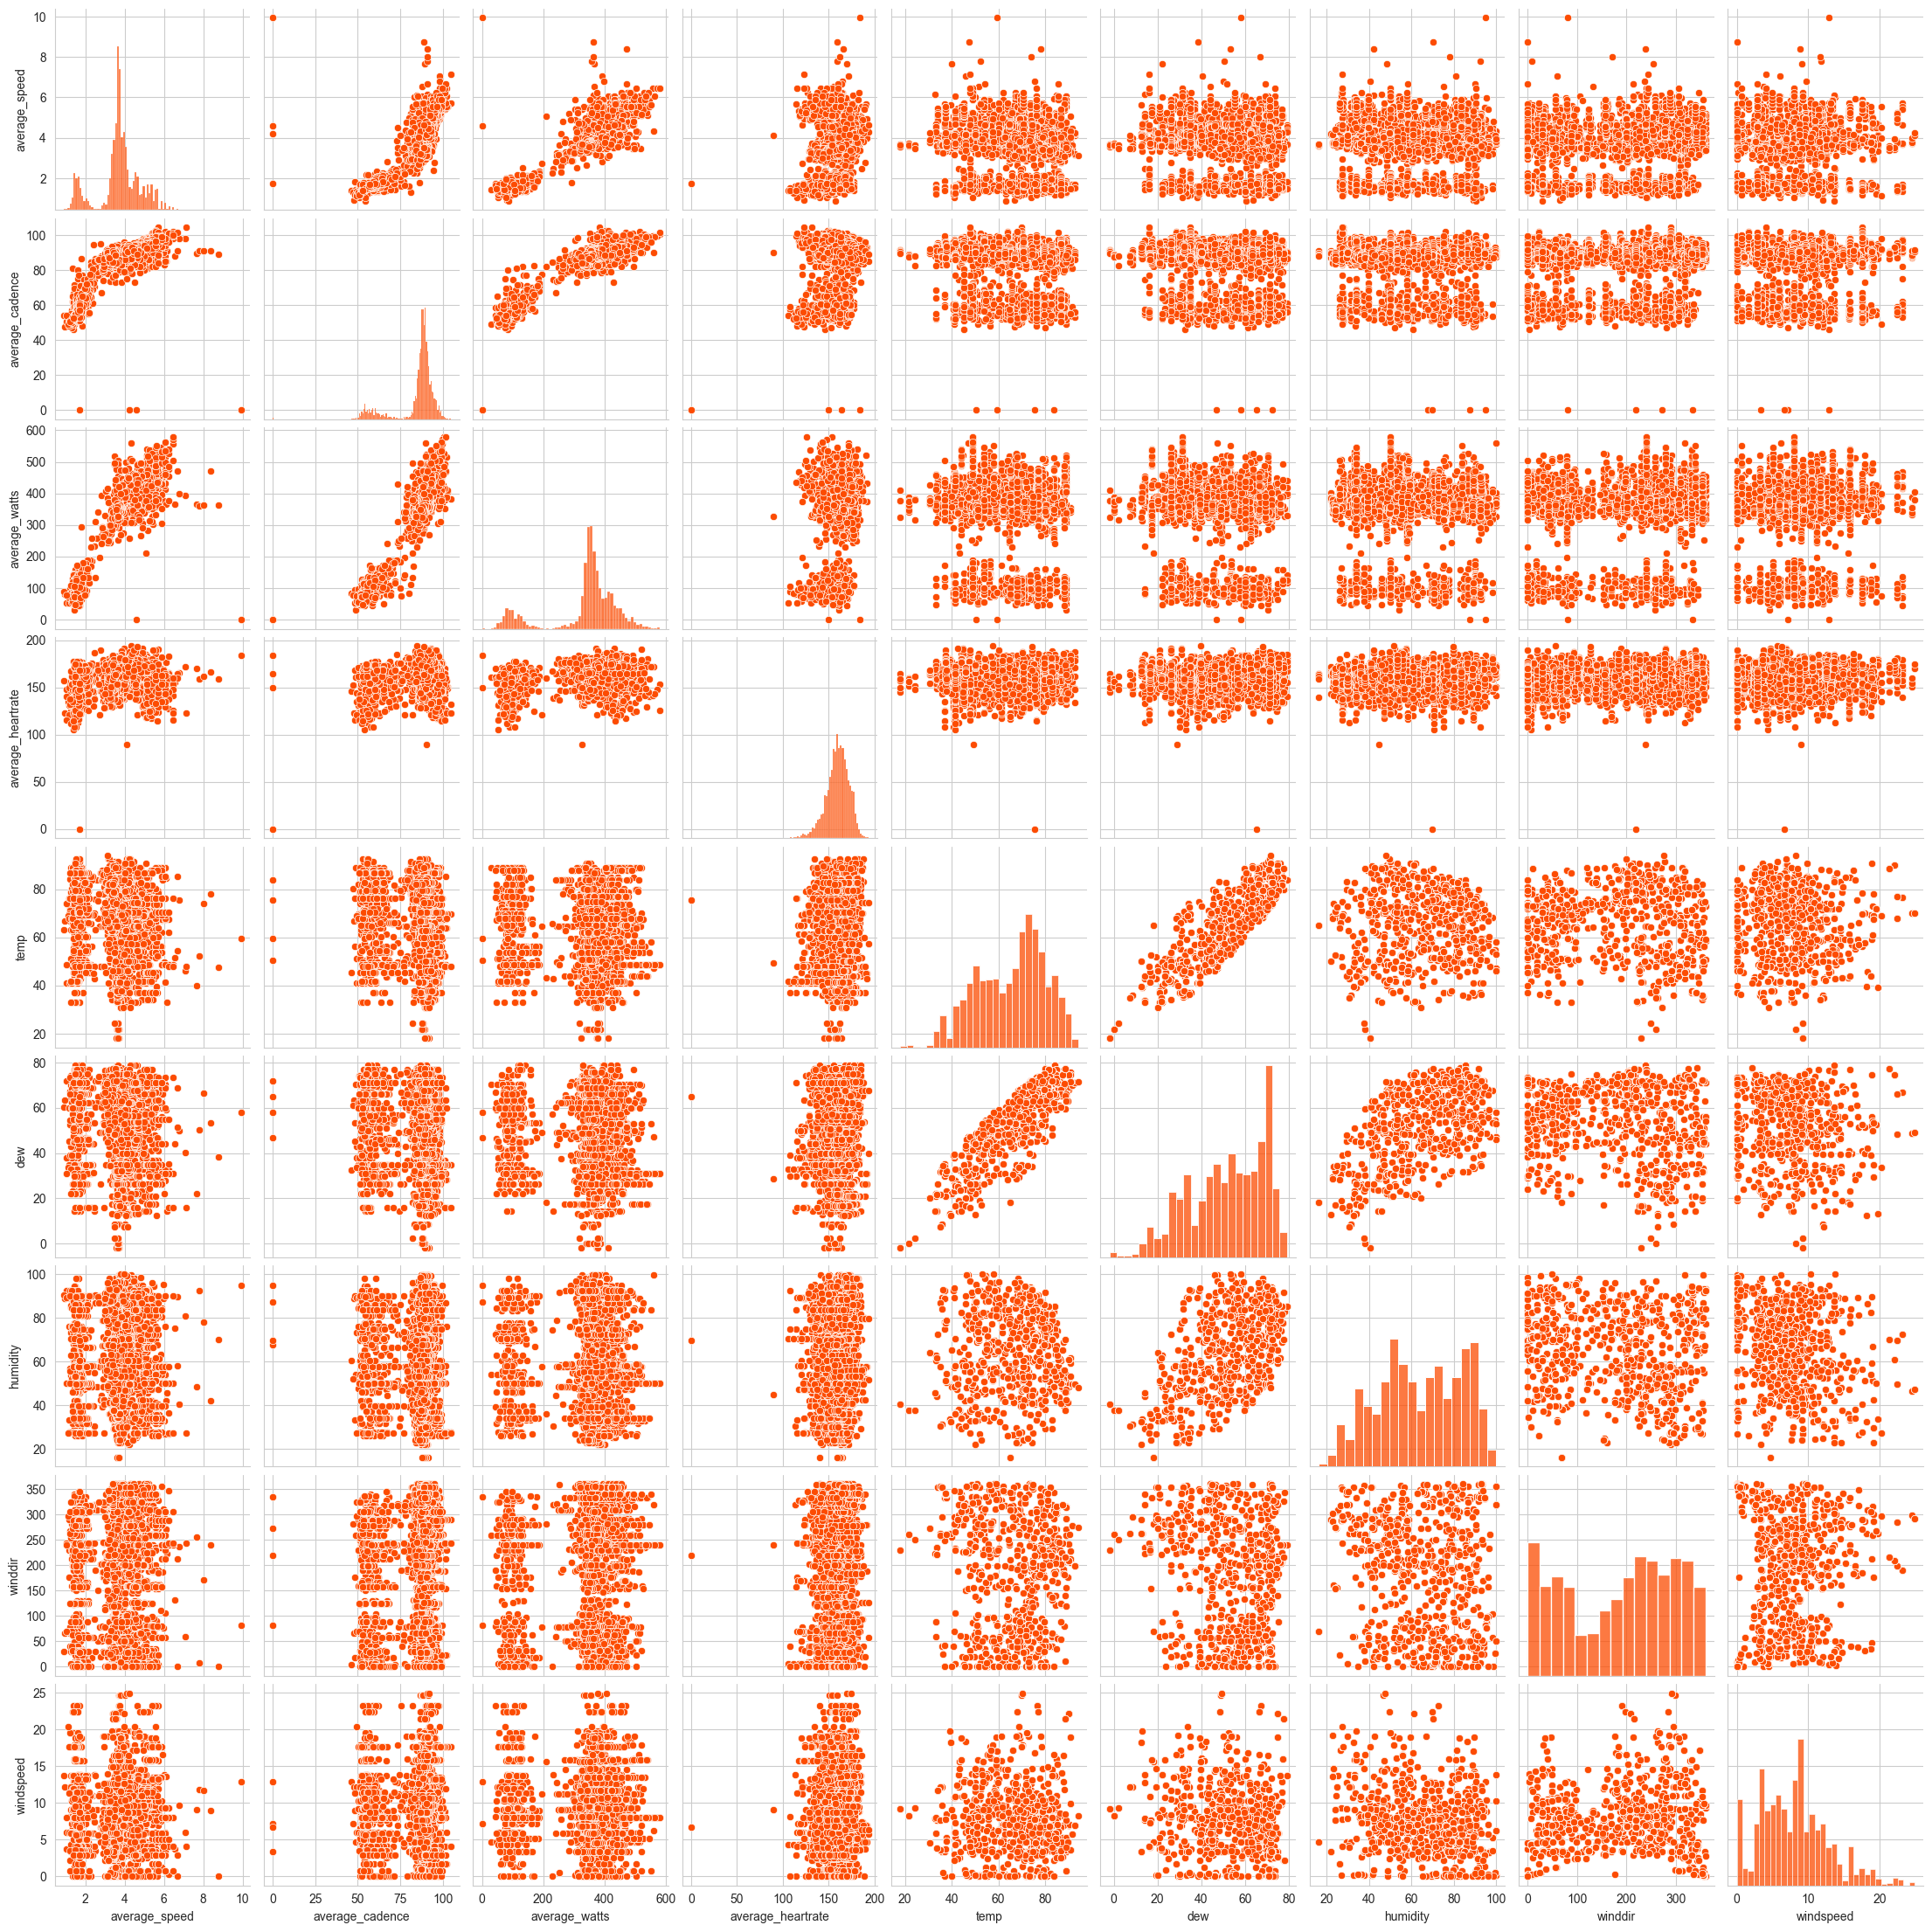

In [89]:
# running info pairplot
sns.pairplot(running_data[['average_speed', 'average_cadence', 'average_watts', 'average_heartrate', 'temp', 'dew', 'humidity', 'winddir', 'windspeed']]);

/Users/bennett/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


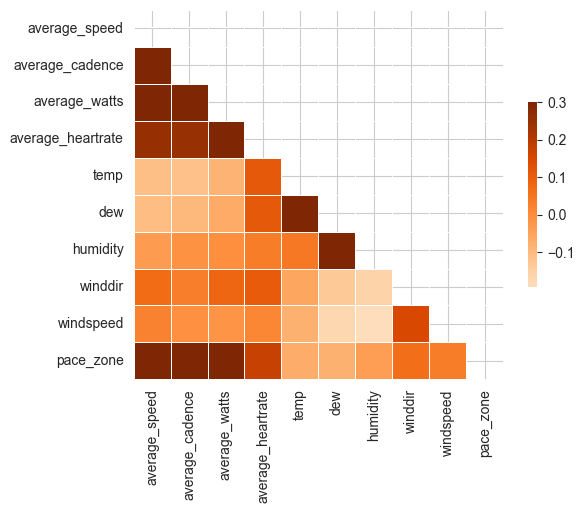

In [88]:
# These parameters for the sns.heatmap are taken from sns.heatmap documentation. It creates a heatmap that very much resembles the corrplot() from R
corr = running_data[['average_speed', 'average_cadence', 'average_watts', 'average_heartrate', 'temp', 'dew', 'humidity', 'winddir', 'windspeed', 'pace_zone']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='Oranges', annot=True,
            vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={'shrink': .5}
            );

We're not really seeing much here. Just like in my research, it's really hard to get a perfect understanding of how the weather is impacting the running variables. This also might partially be due to me being stubborn and trying to hit ranges regardless of the conditions. If this is the case, heartrate should be a good indicator of the relationship.

# Feature Engineering

A few things need to be done here.
- I want to keep track of how much distance has elapsed in the given workout (we can just keep summing distance by lap for each activity). I know that the further and longer an activity goes on, there's some level of impact on your internals. We need to account for it
- I also want to make a conversion for distance and time elapsed to get a mile per min pace variable. This will be helpful for post modelling when we want to chart out the CAPi paces.